<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/Tutorial3_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Matching with Parameter Sharing and regularizations

Goals:
* Create a model that will look at two images and evaluate whether they are the same.
* implement a Siamese neural network
* implement different regularizations in the siamese network


In particular we will try to identify which images match in the USPS and MNIST Dataset.
Given sample $a$ from MNIST and sample $b$ from USPS, are they the same number?

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np

## Load the USPS Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
usps_testset = datasets.USPS(root='./data', train=False, download=True, transform=transform)

In [3]:
usps_trainset[0][0].shape

torch.Size([1, 16, 16])

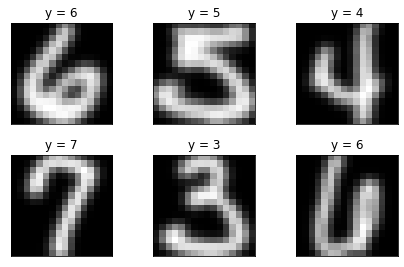

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(usps_trainset[i][0].reshape(16,16), cmap='gray', interpolation='none')
  plt.title("y = {}".format(usps_trainset[i][1]))
  plt.xticks([])
  plt.yticks([])

## Load the MNIST Dataset

In [5]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

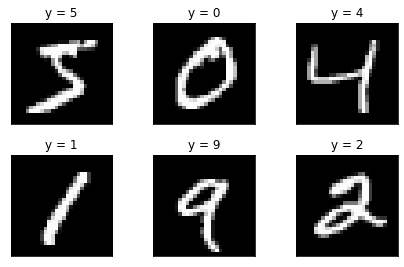

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(mnist_trainset[i][0].reshape(28,28), cmap='gray', interpolation='none')
  plt.title("y = {}".format(mnist_trainset[i][1]))
  plt.xticks([])
  plt.yticks([])

## Create the Dataloaders

In [8]:
train_mnist = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True, drop_last=True)
train_usps = torch.utils.data.DataLoader(usps_trainset, batch_size=128, shuffle=True, drop_last=True) # drop last to match batch size from both datasets

To get a picture of what is happening, we are going to create a dummy validation set.

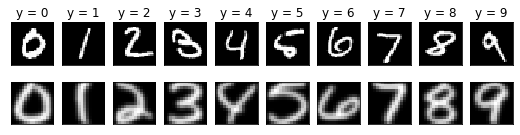

In [9]:
def get_dummy_val(dataset, size):
    dummy_val = torch.Tensor(10, size, size)
    idx = np.ones(10, dtype=int)*-1
    count = 0
    for i, x in enumerate(dataset):
        if idx[x[1]] != -1:
            continue
        else:
            idx[x[1]] = i
            dummy_val[x[1]] = x[0]
            count += 1
        if count == 10:
            break
    return dummy_val

mnist_val = get_dummy_val(mnist_testset, 28)
usps_val = get_dummy_val(usps_testset, 16)

# display first ten samples of combination
fig, axes = plt.subplots(2, 10, figsize=(9,2))
for i in range(10):
    ax = axes[0][i%10]
    ax.imshow(mnist_val[i].reshape(28,28), cmap='gray', interpolation='none')
    ax.set_title("y = {}".format(i))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = axes[1][i%10]
    ax.imshow(usps_val[i].reshape(16,16), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
mnist_val = mnist_val.view(10,-1).unsqueeze(1) #(10, 1, 28*28)
usps_val = usps_val.view(10,-1).unsqueeze(0) #(1, 10, 16*16)

mnist_val = mnist_val.repeat(1,10,1) #(10,10,28*28)
usps_val = usps_val.repeat(10,1,1)   #(10,10,16*16)

val = torch.cat([mnist_val, usps_val],-1).reshape(100,-1)
mnist_val = val[:,:28*28]
usps_val = val[:,28*28:]

In [11]:
print(val.shape)

torch.Size([100, 1040])


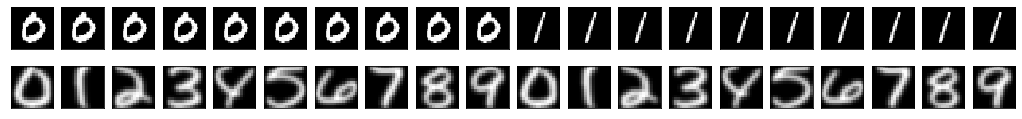

In [12]:
fig, axes = plt.subplots(2, 20, figsize=(18, 2))
for i in range(20):
    ax = axes[0][i]
    ax.imshow(mnist_val[i].reshape(28,28), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = axes[1][i]
    ax.imshow(usps_val[i].reshape(16,16), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
# plt.tight_layout()

In [13]:
val_label = torch.eye(10).reshape(-1)
np_val_label = np.eye(10, dtype=int).reshape(-1) # just so we do not keep on changing the datatype of this

## Training Loop

Let's create the training loop beforehand because we will experiment with different regularizations. Since the dataset is imbalaced (about 1/10 of the samples match in each batch if we sample independently from both datasets), we are going to use the AUC as the validation metric.

In [14]:
import sklearn.metrics as metrics

def train(model, data1, data2, val_data, num_epoch, loss_func, optimizer, device):
    for i in range(num_epoch):
        model.train()
        data = zip(data1, data2)
        for (x1, y1), (x2, y2) in data:        
            # move the data to gpu
            x1, x2 = x1.to(device), x2.to(device) 
            y = ((y1 == y2)*1.0).view(-1,1).to(device) # 1 if they match, 0 otherwise
    
            # reset the gradients
            optimizer.zero_grad() 
            # x1.shape = (batch, 1, 28,28)
            y_hat = model(x1.view(-1, 28*28), x2.view(-1, 16*16))
            batch_loss = loss_func(y_hat, y, model)
            batch_loss.backward() # autodiff
            optimizer.step() # weight update
        
        model.eval()
        with torch.no_grad():
            pred = model(val_data[0].to(device), val_data[1].to(device))
            val_loss = loss_func(pred, val_label.to(device), model)
            pred = pred[0].detach().cpu().numpy() 

            fpr, tpr, thresholds = metrics.roc_curve(np_val_label,pred.reshape(-1))
            auc = metrics.auc(fpr, tpr)
            
        print(i, batch_loss.item(), val_loss.item(), auc)
    return model

# Create our matching neural networks

One way of pattern matching is to simply create 2 parallel neural networks and then concatene the representation learned at some point. You can then formulate this as a binary classification problem like the example below:

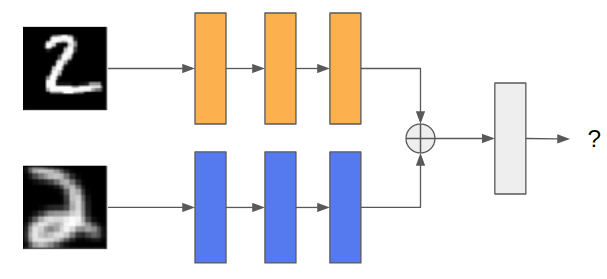

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class MatchingNetworkV1(nn.Module):
    def __init__(self, mnist_in, usps_in):
        super(MatchingNetworkV1, self).__init__()
        self.layer1_mnist = nn.Linear(mnist_in, 64)
        self.layer1_usps = nn.Linear(usps_in, 64)
        
        self.layer2_mnist = nn.Linear(64, 32)
        self.layer2_usps = nn.Linear(64, 32)
        
        self.layer3_mnist = nn.Linear(32, 16)
        self.layer3_usps = nn.Linear(32, 16)
        
        self.out = nn.Linear(32,1)
    
    def forward(self, x1, x2):
        x1 = F.relu(self.layer1_mnist(x1))
        x1 = F.relu(self.layer2_mnist(x1))
        x1 = F.relu(self.layer3_mnis(x1))
        
        x2 = F.relu(self.layer1_usps(x2))
        x2 = F.relu(self.layer2_usps(x2))
        x2 = F.relu(self.layer3_usps(x2))
        return self.out(torch.cat([x1,x2], -1))

The one above is a viable option but it is prone to overfitting due to overparametrization. Furthermore, **it does not take advantage of the fact that higher-level representations of the features may have similar patterns** and thus we can share the parameters like the example below.

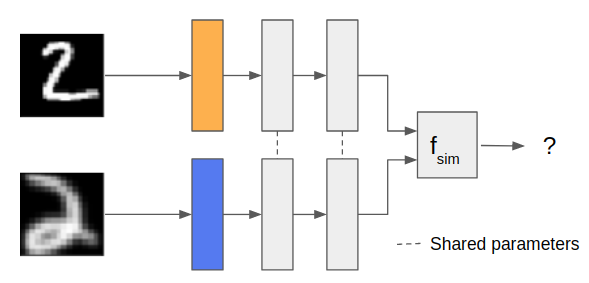

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class MatchingNetwork(nn.Module):
    def __init__(self, mnist_in, usps_in):
        super(MatchingNetwork, self).__init__()
        self.layer1_mnist = nn.Linear(mnist_in, 128)
        self.layer1_usps = nn.Linear(usps_in, 128)
        
        self.layer2 = nn.Linear(128, 64) # shared between the mnist and usps track
        self.layer3 = nn.Linear(64, 32) # shared between the mnist and usps track
    
    def forward(self, x1, x2):
        x1 = F.relu(self.layer1_mnist(x1))
        x1 = F.relu(self.layer2(x1))
        x1 = torch.tanh(self.layer3(x1))
        
        x2 = F.relu(self.layer1_usps(x2))
        x2 = F.relu(self.layer2(x2))
        x2 = torch.tanh(self.layer3(x2))
        return F.cosine_similarity(x1,x2), x1, x2 # return cosine similarity and embedding of image1 and image2

Notice we don't have an open layer in the above network as it is not necessary, because we are interested in whether the samples $x_1$ and $x_2$ are similar and we don't need a predictor for this. We can simply look at their similarity using the cosine similarity of the vector embeddings of the two samples are similar or not. 

In the NN above, we can see that instead of having a single output layer, we used the cosine similarity of the embeddings of the two inputs say $\hat{x}_a$ and $\hat{x}_b$. 

$sim(\hat{x}_a, \hat{x}_b) \in [-1,1]$, which we can interpret as follows:
*  $sim(\hat{x}_a, \hat{x}_b) = -1$: the embeddings go on opposite ways
*  $sim(\hat{x}_a, \hat{x}_b) = 0$: the embeddings are orthogonal
*  $sim(\hat{x}_a, \hat{x}_b) = 1$: the embeddings are pointed towards the same direction

With that, a simplification to a binary task would be to set $0$ as the threshold. Note that the cosine similarity doesn't care about the magnitude of the embeddings, it only cares that the enbeddings are pointing to the same direction. If the cosine similarity is greater than 0, then it is the same digit, otherwise they are different digits. 

Loss function and Optimizer

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)
cosemb = nn.CosineEmbeddingLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [19]:
def loss_func(y_hat, y, model):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))
    return loss

 Let us train model...

In [20]:
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func, optimizer, device)


0 14.58441162109375 10.36087417602539 0.5577777777777777
1 14.312637329101562 10.241277694702148 0.6488888888888888
2 11.101593017578125 10.083703994750977 0.7233333333333334
3 12.074882507324219 10.057180404663086 0.7622222222222222
4 12.103838920593262 10.07959270477295 0.7677777777777778
5 10.170928955078125 10.091943740844727 0.77
6 10.246536254882812 9.959794998168945 0.7611111111111111
7 15.56801986694336 9.930837631225586 0.7844444444444445
8 9.960027694702148 9.38200569152832 0.8044444444444445
9 16.26450538635254 9.195347785949707 0.8244444444444444
10 16.493667602539062 9.061634063720703 0.8355555555555556
11 13.19207763671875 9.10322093963623 0.7866666666666666
12 9.074769973754883 9.041851997375488 0.8211111111111111
13 8.123575210571289 9.039430618286133 0.81
14 7.179258823394775 9.10268783569336 0.8044444444444444
15 13.86237621307373 9.085731506347656 0.8
16 16.023555755615234 9.08997917175293 0.8022222222222223
17 3.1420600414276123 9.002881050109863 0.8233333333333333


Let's look at the results in the validation set

In [21]:
import pandas as pd

pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.983103,-0.069811,-0.156832,-0.209692,-0.279656,-0.144487,-0.347104,-0.146836,-0.198113,-0.223498
1,-0.041208,0.998191,-0.117941,-0.201437,-0.101106,-0.273316,-0.163532,-0.092669,-0.078627,-0.099861
2,-0.119486,-0.091869,0.993452,-0.128950,-0.134774,-0.154155,-0.269697,-0.138420,-0.240420,-0.183433
3,-0.260931,-0.094922,-0.163511,0.004366,-0.057109,-0.010423,-0.142225,-0.336532,-0.010646,-0.074665
4,-0.269870,-0.062977,-0.198874,-0.049469,0.032791,-0.064744,-0.117889,-0.123613,-0.032735,0.025270
5,-0.289726,-0.041481,-0.176119,-0.032732,0.042943,-0.058290,-0.068885,-0.224885,-0.004443,0.031362
6,-0.393644,-0.150674,-0.357665,-0.070947,-0.111838,-0.089247,0.914676,-0.143166,-0.044207,-0.136300
7,-0.060546,-0.083630,-0.095888,-0.184680,-0.159237,-0.140465,-0.050518,0.997058,-0.232733,-0.130350
8,-0.257777,-0.017523,-0.107211,-0.033048,-0.030881,-0.073892,-0.074601,-0.457192,0.002786,-0.056311
9,-0.175633,-0.132726,-0.238841,-0.031761,-0.001353,-0.027853,-0.159028,-0.155443,-0.037051,-0.000372


In [ ]:
pd.DataFrame(1*(pred[0].detach().cpu().numpy().reshape(10,10)>0))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,1,1
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0,0,1,1
9,0,0,0,0,0,0,0,0,0,1


In [22]:
vl = val_label + 1*(val_label-1)
c = F.cosine_embedding_loss(pred[1], pred[2], torch.tensor(vl).view(-1).to(device), reduction='none')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [23]:
pd.DataFrame(c.detach().cpu().numpy().reshape(10,10))


,0,1,2,3,4,5,6,7,8,9
0,0.016897,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.001809,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.006548,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.995634,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.967209,0.00000,0.000000,0.000000,0.000000,0.025270
5,0.000000,0.000000,0.000000,0.000000,0.042943,1.05829,0.000000,0.000000,0.000000,0.031362
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.085324,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.002942,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.997214,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000372


## More Regularization Examples

### Built-in L2 regularization

In [24]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) # The weight decay parameter is the L2 regularization
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func, optimizer, device)

0 12.591830253601074 10.538933753967285 0.5911111111111111
1 12.052472114562988 10.128011703491211 0.6377777777777778
2 13.106101989746094 10.097835540771484 0.6677777777777778
3 15.12053108215332 10.039948463439941 0.6944444444444444
4 11.310114860534668 10.032524108886719 0.6922222222222222
5 19.026533126831055 10.011336326599121 0.7011111111111111
6 18.98965835571289 9.851827621459961 0.7055555555555555
7 10.76736831665039 9.382217407226562 0.6966666666666667
8 9.16348648071289 9.19870662689209 0.7200000000000001
9 13.43178939819336 9.09868049621582 0.74
10 7.183056831359863 9.184762001037598 0.7433333333333333
11 12.695860862731934 9.143226623535156 0.7488888888888888
12 13.881646156311035 9.09190559387207 0.7711111111111112
13 8.06957721710205 9.040841102600098 0.8422222222222223
14 10.2543363571167 9.070549964904785 0.768888888888889
15 8.033468246459961 9.104321479797363 0.8188888888888889
16 9.02485466003418 9.052366256713867 0.8277777777777777
17 19.37505531311035 9.1349592208

### Manual L1/L2 regularization

In [25]:
def loss_func_with_reg(y_hat, y, model, lambda_=1e-5):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))

    l1_reg = 0
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)

    return loss + lambda_*l1_reg 

In [26]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func_with_reg, optimizer, device)

0 17.631267547607422 10.32147216796875 0.6311111111111112
1 16.41417694091797 10.223260879516602 0.7111111111111111
2 15.185198783874512 10.08562183380127 0.7155555555555555
3 17.232013702392578 10.142118453979492 0.7322222222222222
4 11.307170867919922 10.193510055541992 0.8055555555555556
5 13.22864055633545 10.043094635009766 0.7766666666666667
6 7.169320106506348 10.233023643493652 0.79
7 9.286914825439453 9.939332962036133 0.8022222222222223
8 9.652833938598633 9.613845825195312 0.8111111111111111
9 8.611138343811035 9.2266263961792 0.7755555555555556
10 14.315803527832031 9.133842468261719 0.7955555555555556
11 12.380925178527832 9.11693000793457 0.81
12 14.409698486328125 9.212495803833008 0.8244444444444444
13 10.073664665222168 9.077164649963379 0.8111111111111111
14 8.413851737976074 9.16372299194336 0.8255555555555556
15 18.102102279663086 9.24274730682373 0.8277777777777777
16 17.16167449951172 9.074243545532227 0.8322222222222222
17 16.077945709228516 9.070701599121094 0.8

In [27]:
pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.997422,-0.072022,-0.203516,-0.175424,-0.046197,-0.062797,-0.232761,-0.074758,-0.076035,-0.100130
1,-0.101338,0.995617,-0.049436,-0.068458,-0.247650,-0.095432,-0.116403,-0.043367,-0.148848,-0.192254
2,-0.119743,-0.062183,0.988492,-0.187121,-0.220020,-0.187135,-0.301506,-0.163408,-0.217028,-0.231158
3,-0.349723,-0.116376,-0.113367,0.051204,-0.061105,0.048160,-0.001429,-0.411986,0.044852,-0.069221
4,-0.157830,-0.131935,-0.241297,-0.167029,0.004739,-0.144416,-0.033660,-0.172651,-0.062898,-0.002931
5,-0.109068,-0.189485,-0.310275,-0.185506,0.028616,-0.146794,0.107043,-0.254104,-0.044810,0.012266
6,-0.156895,-0.176816,-0.334953,-0.208078,-0.137587,-0.155765,0.439014,-0.447226,-0.086158,-0.173191
7,-0.093665,-0.082998,-0.066507,-0.075268,-0.175829,-0.215503,-0.234782,0.990720,-0.268019,-0.121966
8,-0.126489,-0.184662,0.043360,-0.136696,-0.006842,-0.070368,-0.164184,-0.417914,-0.011128,-0.037178
9,-0.170548,-0.165393,-0.253094,-0.047265,-0.013729,-0.051004,-0.106920,-0.166052,-0.017116,-0.020770


# Hmmmm... It seems like this is not an easy problem after all
What else can we do?

1. Data Augmentation?
2. Label smoothing?
3. Multi-task Learning?  
4. CNN (\*rolls eyes\* obviously)


## (Pseudo) Data Augmentatation

We expect that only 1/10 of our samples match. Instead of oversampling matching pairs (which will require more effort in practice), we can do sample weighting instead.

 This can be done by giving more weight to the minority samples in the loss function.

In [28]:
cosemb = nn.CosineEmbeddingLoss(reduction='none')
def loss_func_augmented(y_hat, y, model):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))*(1+y*10)
    return loss.mean()

In [29]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func_augmented, optimizer, device)

0 0.2351340502500534 1.1241779327392578 0.5822222222222222
1 0.20729610323905945 1.1092208623886108 0.6744444444444445
2 0.3121315538883209 1.0998194217681885 0.7722222222222223
3 0.2590060532093048 1.1130818128585815 0.7766666666666667
4 0.20485875010490417 1.0986415147781372 0.7633333333333334
5 0.15610715746879578 1.086981177330017 0.8055555555555556
6 0.24191340804100037 1.0828008651733398 0.81
7 0.18845684826374054 1.0306377410888672 0.7966666666666666
8 0.20508620142936707 1.0031107664108276 0.7966666666666666
9 0.16394741833209991 1.0214442014694214 0.7944444444444445
10 0.13313671946525574 0.9942450523376465 0.8366666666666667
11 0.18127399682998657 0.9853455424308777 0.8533333333333334
12 0.18983052670955658 0.9863458871841431 0.8922222222222222
13 0.21429237723350525 0.9859257340431213 0.8633333333333333
14 0.21486708521842957 1.0011022090911865 0.8933333333333333
15 0.18296605348587036 0.9988012313842773 0.8433333333333333
16 0.26134130358695984 0.9845137000083923 0.89888888

In [30]:
pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.993339,-0.075127,-0.152804,-0.079400,-0.132211,0.079334,-0.206528,-0.021560,-0.085004,-0.134027
1,-0.108068,0.995757,-0.091670,-0.060367,-0.125824,-0.197352,-0.055510,-0.099673,-0.139931,-0.090076
2,-0.164459,-0.107684,0.988238,-0.253320,-0.199716,-0.409651,-0.337750,-0.185073,-0.295084,-0.202492
3,-0.112611,-0.159248,-0.331381,-0.034593,-0.020295,0.079295,-0.144825,-0.057373,0.029697,-0.035784
4,-0.241226,-0.087164,-0.109125,-0.180927,0.013681,-0.056776,-0.113464,-0.134933,0.001219,0.025718
5,-0.229071,-0.175468,-0.117069,-0.164345,0.005747,-0.028196,-0.060681,-0.183974,0.011918,0.001778
6,-0.191997,-0.172016,-0.418114,-0.110872,-0.073830,-0.026353,0.898937,-0.163977,-0.010821,-0.101701
7,-0.083598,-0.072940,-0.154822,-0.099390,-0.090259,-0.089938,-0.074921,0.996857,-0.104451,-0.085372
8,-0.169882,-0.241555,0.058462,-0.170088,-0.010469,-0.016085,-0.214153,-0.294743,-0.001824,-0.027214
9,-0.234097,-0.089827,-0.054923,-0.145420,0.016379,-0.041421,-0.222006,-0.169364,0.002715,0.026910


In [31]:
pd.DataFrame(1*(pred[0].detach().cpu().numpy().reshape(10,10)>0))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,1,1
5,0,0,0,0,1,0,0,0,1,1
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,1,1
